In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import *
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, LogisticRegressionCV
from sklearn.utils import shuffle
from scipy import stats as st
from statsmodels.api import OLS
import random
random.seed(42)
np.random.seed(42)
random_state = np.random.RandomState(42)
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#missing value ratio
def missing_values(df):
    df_nulls=pd.concat([df.dtypes, df.isna().sum(), df.isna().sum()/len(df)], axis=1)
    df_nulls.columns = ["type","count","missing_ratio"]
    df_nulls=df_nulls[df_nulls["count"]>0]
    df_nulls.sort_values(by="missing_ratio", ascending=False)
    return df_nulls

#outliers by 3 sigma rule
def outlier(data):
    data_mean, data_std = np.mean(data), np.std(data)
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers = [x for x in data if x < lower or x > upper]
    outliers_removed = [x for x in data if x >= lower and x <= upper]
    return len(outliers)

# full description statistics 
def describe_full(df, target_name=""):
    data_describe = df.describe().T
    df_numeric = df._get_numeric_data()
    if target_name in df.columns:
        corr_with_target=df_numeric.drop(target_name, axis=1).apply(lambda x: x.corr(df_numeric[target_name]))
        data_describe['corr_with_target']=corr_with_target
    dtype_df = df_numeric.dtypes
    data_describe['dtypes'] = dtype_df
    data_null = df_numeric.isnull().sum()/len(df) * 100
    data_describe['Missing %'] = data_null
    Cardinality = df_numeric.apply(pd.Series.nunique)
    data_describe['Cardinality'] = Cardinality
    df_skew = df_numeric.skew(axis=0, skipna=True)
    data_describe['Skew'] = df_skew
    data_describe['outliers']=[outlier(df_numeric[col]) for col in df_numeric.columns]
    data_describe['kurtosis']=df_numeric.kurtosis()
    return data_describe

In [3]:
def display_group_density_plot(df, groupby, on, palette, figsize):
    """
    Displays a density plot by group, given a continuous variable, and a group to split the data by
    :param df: DataFrame to display data from
    :param groupby: Column name by which plots would be grouped (Categorical, maximum 10 categories)
    :param on: Column name of the different density plots
    :param palette: Color palette to use for drawing
    :param figsize: Figure size
    :return: matplotlib.axes._subplots.AxesSubplot object
    """

    if not isinstance(df, pd.core.frame.DataFrame):
        raise ValueError('df must be a pandas DataFrame')

    if not groupby:
        raise ValueError('groupby parameter must be provided')

    elif not groupby in df.keys():
        raise ValueError(groupby + ' column does not exist in the given DataFrame')

    if not on:
        raise ValueError('on parameter must be provided')

    elif not on in df.keys():
        raise ValueError(on + ' column does not exist in the given DataFrame')

    if len(set(df[groupby])) > 10:
        groups = df[groupby].value_counts().index[:10]

    else:
        groups = set(df[groupby])

    # Get relevant palette
    if palette:
        palette = palette[:len(groups)]
    else:
        palette = sns.color_palette()[:len(groups)]

    # Plot
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')

    for value, color in zip(groups, palette):
        sns.kdeplot(df.loc[df[groupby] == value][on], \
                    shade=True, color=color, label=value)

    ax.set_title(str("Distribution of " + on + " per " + groupby + " group"),\
                 fontsize=30)
    
    ax.set_xlabel(on, fontsize=20)
    return ax 

# Project Description

<div class="markdown markdown_size_normal markdown_type_theory"><div class="paragraph">You work for the OilyGiant mining company. Your task is to find the best place for a new well.</div><div class="paragraph">Steps to choose the location:</div><ul><li>Collect the oil well parameters in the selected region: oil quality and volume of reserves;</li><li>Build a model for predicting the volume of reserves in the new wells;</li><li>Pick the oil wells with the highest estimated values;</li><li>Pick the region with the highest total profit for the selected oil wells.</li></ul><div class="paragraph">You have data on oil samples from three regions. Parameters of each oil well in the region are already known. Build a model that will help to pick the region with the highest profit margin. Analyze potential profit and risks using the <em>Bootstrapping</em> technique.</div></div>

# 1. Download and prepare the data. Explain the procedure.

<h3>Data description</h3><div class="paragraph">Geological exploration data for the three regions are stored in files:</div><ul><li><code class="code-inline code-inline_theme_light">geo_data_0.csv</code>. <a href="https://code.s3.yandex.net/datasets/geo_data_0.csv" target="_blank">download dataset</a></li><li><code class="code-inline code-inline_theme_light">geo_data_1.csv</code>. <a href="https://code.s3.yandex.net/datasets/geo_data_1.csv" target="_blank">download dataset</a></li><li><code class="code-inline code-inline_theme_light">geo_data_2.csv</code>. <a href="https://code.s3.yandex.net/datasets/geo_data_2.csv" target="_blank">download dataset</a></li><li><em>id</em> — unique oil well identifier</li><li><em>f0, f1, f2</em> — three features of points (their specific meaning is unimportant, but the features themselves are significant)</li><li><em>product</em> — volume of reserves in the oil well (thousand barrels).</li></ul><div class="paragraph"><strong>Conditions:</strong></div><ul><li>Only linear regression is suitable for model training (the rest are not sufficiently predictable).</li><li>When exploring the region, a study of 500 points is carried with picking the best 200 points for the profit calculation.</li><li>The budget for development of 200 oil wells is 100 USD million.</li><li>One barrel of raw materials brings 4.5 USD of revenue The revenue from one unit of product is 4,500 dollars (volume of reserves is in thousand barrels).</li><li>After the risk evaluation, keep only the regions with the risk of losses lower than 2.5%. From the ones that fit the criteria, the region with the highest average profit should be selected.</li></ul><div class="paragraph">The data is synthetic: contract details and well characteristics are not disclosed.</div>

In [4]:
geo_data_0 = pd.read_csv("https://code.s3.yandex.net/datasets/geo_data_0.csv")
geo_data_1 = pd.read_csv("https://code.s3.yandex.net/datasets/geo_data_1.csv")
geo_data_2 = pd.read_csv("https://code.s3.yandex.net/datasets/geo_data_2.csv")

In [5]:
geo_data_0.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [6]:
geo_data_1.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [7]:
geo_data_2.isna().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [8]:
describe_full(geo_data_0)

,count,mean,std,min,25%,50%,75%,max,dtypes,Missing %,Cardinality,Skew,outliers,kurtosis
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331,float64,0.0,100000,-0.000337,0,-0.868909
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769,float64,0.0,100000,0.000717,0,-1.186068
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790,float64,0.0,100000,-0.002996,178,-0.111284
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347,float64,0.0,100000,0.004816,0,-0.951506


In [9]:
describe_full(geo_data_1)

,count,mean,std,min,25%,50%,75%,max,dtypes,Missing %,Cardinality,Skew,outliers,kurtosis
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755,float64,0.0,100000,0.001992,7,-0.947124
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063,float64,0.0,100000,0.016597,262,-0.023065
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721,float64,0.0,100000,0.006666,0,-1.261794
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408,float64,0.0,12,0.006685,0,-1.259374


In [10]:
describe_full(geo_data_2)

,count,mean,std,min,25%,50%,75%,max,dtypes,Missing %,Cardinality,Skew,outliers,kurtosis
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262,float64,0.0,100000,0.003941,266,0.015364
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801,float64,0.0,100000,0.014802,281,-0.012328
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402,float64,0.0,100000,0.004057,201,-0.068082
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838,float64,0.0,100000,0.004655,0,-0.878423


In [11]:
target = "product"
features = ['f0', 'f1', 'f2']

In [12]:
gd1 = geo_data_0.copy()
gd1["source"] = "geo_data_0"
gd2 = geo_data_1.copy()
gd2["source"] = "geo_data_1"
gd3 = geo_data_2.copy()
gd3["source"] = "geo_data_2"
df = pd.concat([gd1, gd2, gd3])
del gd1,gd2,gd3

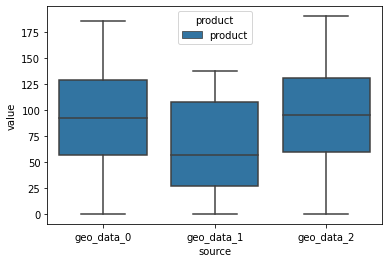

<Figure size 432x288 with 0 Axes>

In [13]:
mdf = pd.melt(df[[target, 'source']], id_vars=['source'], var_name=[target])
ax = sns.boxplot(x="source", y="value", hue=target, data=mdf)    
plt.show()
plt.clf()

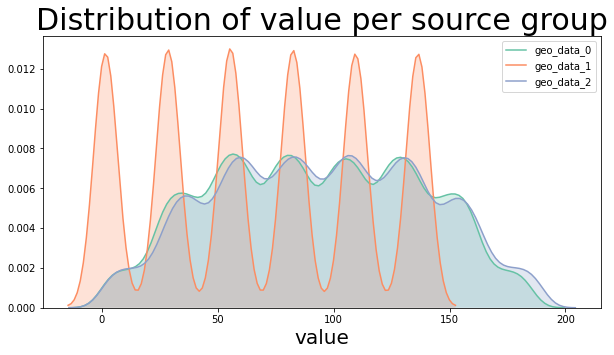

In [14]:
display_group_density_plot(mdf, groupby = "source", on = 'value', \
                                           palette = sns.color_palette('Set2'), 
                           figsize = (10, 5))

### Summary

we have 3 datasets, without missing data, with the same counts, dataset1 and dataset3 have around similar mean value and distribution of the product compare with the dataset2

# 2. Train and test the model for each region:

## 2.1. Split the data into a training set and validation set at a ratio of 75:25.


## 2.2. Train the model and make predictions for the validation set.


## 2.3. Save the predictions and correct answers for the validation set.


## 2.4. Print the average volume of predicted reserves and model RMSE.


In [15]:
def test_lr_model(X_train,X_valid,y_train,y_valid):
  lr = LinearRegression().fit(X_train,y_train)
  y_pred = lr.predict(X_valid)  
  return mean_squared_error(y_valid, y_pred,squared=False), lr.score(X_valid, y_valid), y_pred

In [16]:
X_train0,X_valid0,y_train0,y_valid0 = train_test_split(geo_data_0[features].values,geo_data_0[target].values,test_size=0.25, random_state=42)
rmse, score, y_pred0 = test_lr_model(X_train0,X_valid0,y_train0,y_valid0)
print(f"RMSE: {rmse}")
print(f"R^2: {score}")
print(f"y_pred_mean: {y_pred0.mean()}")

RMSE: 37.75660035026169
R^2: 0.2728287328173471
y_pred_mean: 92.39879990657776


In [17]:
X_train1,X_valid1,y_train1,y_valid1 = train_test_split(geo_data_1[features].values,geo_data_1[target].values,test_size=0.25, random_state=42)
rmse, score, y_pred1 = test_lr_model(X_train1,X_valid1,y_train1,y_valid1)
print(f"RMSE: {rmse}")
print(f"R^2: {score}")
print(f"y_pred_mean: {y_pred1.mean()}")

RMSE: 0.8902801001028893
R^2: 0.9996245232002449
y_pred_mean: 68.71287803913718


In [18]:
X_train2,X_valid2,y_train2,y_valid2 = train_test_split(geo_data_2[features].values,geo_data_2[target].values,test_size=0.25, random_state=42)
rmse, score, y_pred2 = test_lr_model(X_train2,X_valid2,y_train2,y_valid2)
print(f"RMSE: {rmse}")
print(f"R^2: {score}")
print(f"y_pred_mean: {y_pred2.mean()}")

RMSE: 40.145872311342174
R^2: 0.19634705977280487
y_pred_mean: 94.7710238776594


In [19]:
def test_model_cv(df):
  """
  cross-validation checker of linear regression model 
  (also we could use LinearRegressionCV)
  """
  shuffle(df)
  X, y = df[features].values, df[target].values
  result = dict(rmse=[], score=[])
  for train_index, valid_index in KFold(n_splits=5).split(X):
    scaler = StandardScaler()
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_valid = scaler.transform(X_valid)
    rmse, score, _ = test_lr_model(X_train, X_valid, y_train, y_valid)
    result["rmse"].append(rmse)
    result["score"].append(score)
  return pd.DataFrame(result)

In [20]:
test_model_cv(geo_data_0).describe().T['mean']

rmse     37.694273
score     0.275491
Name: mean, dtype: float64

In [21]:
test_model_cv(geo_data_1).describe().T['mean']

rmse     0.890408
score    0.999624
Name: mean, dtype: float64

In [22]:
test_model_cv(geo_data_2).describe().T['mean']

rmse     40.056880
score     0.198716
Name: mean, dtype: float64

## 2.5. Analyze the results.

We got next results for our models:

RMSE: 37.76
$R^2$: 0.27
y_pred_mean: 92.40

RMSE: 0.89
$R^2$: 0.99
y_pred_mean: 68.71

RMSE: 40.15
$R^2$: 0.19
y_pred_mean: 94.77

and for cross-validation:
<div class="output_subarea output_html rendered_html"><div>
<style scoped="">
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>geo_data0</th>
      <th>geo_data1</th>
      <th>geo_data2</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>rmse</th>
      <td>37.694273</td>
      <td>0.890408</td>
      <td>40.056880</td>
    </tr>
    <tr>
      <th>score</th>
      <td>0.275491</td>
      <td>0.999624</td>
      <td>0.198716</td>
    </tr>
  </tbody>
</table>
</div></div>



and we see a picture that fits in well with distribution, datasets1 and 2, have pretty similar results, RMSE around 40, and the high mean of predicted value around 90. and dataset 2 has good low metric RMSE around 0.89 but also low mean predicted value. on the other hand the second dataset has really good coeff of the determination in contradistinction to the others datasets

# 3. Prepare for profit calculation:

## 3.1 Store all key values for calculations in separate variables.

<div class="paragraph"><strong>Conditions:</strong></div><ul><li>Only linear regression is suitable for model training (the rest are not sufficiently predictable).</li><li>When exploring the region, a study of 500 points is carried with picking the best 200 points for the profit calculation.</li><li>The budget for development of 200 oil wells is 100 USD million.</li><li>One barrel of raw materials brings 4.5 USD of revenue The revenue from one unit of product is 4,500 dollars (volume of reserves is in thousand barrels).</li><li>After the risk evaluation, keep only the regions with the risk of losses lower than 2.5%. From the ones that fit the criteria, the region with the highest average profit should be selected.</li></ul><div class="paragraph">The data is synthetic: contract details and well characteristics are not disclosed.</div>

## 3.2 Calculate the volume of reserves sufficient for developing a new well without losses. Compare the obtained value with the average volume of reserves in each region.

In [23]:
n_points_all = 500
n_points = 200
budget_total = 100_000_000 #for 200
income_per_volume = 4500
thres_risk_max = 2.5/100
budget_per_one = budget_total/n_points
unit_of_volume = 1000 #Barrels

worst scenario and best, when we expore all of points and when we since the first time found out best of the wells

In [24]:
#the bad scenario
(budget_total*n_points_all/n_points)/n_points/income_per_volume

277.77777777777777

In [25]:
#best
print(f"the volume of reserves sufficient for developing a new well without losses = {budget_total/n_points/income_per_volume:.2f}")

the volume of reserves sufficient for developing a new well without losses = 111.11


## 3.3. Provide the findings about the preparation for profit calculation step.

average predicted volumes that we found  92.40,68.71,94.77 and it's less than 111.11, the volume of reserves sufficient for developing a new well without losses, therefore it's our baseline for finding sufficient wells

# 4. Write a function to calculate profit from a set of selected oil wells and model predictions:
## 4.1 Pick the wells with the highest values of predictions.
## 4.2 Summarize the target volume of reserves in accordance with these predictions
## 4.3 Provide findings: suggest a region for oil wells' development and justify the choice. Calculate the profit for the obtained volume of reserves.

In [26]:
def revenue(target, predicted, count):
    indices = predicted.sort_values(ascending=False).index
    return target[indices][:count].sum() * income_per_volume - budget_total

In [27]:
def revenue(target, predicted, well_count):
    predicted_sorted = predicted.sort_values(ascending=False)
    selected = target[predicted_sorted.index][:well_count]
    return selected.sum() * income_per_volume - budget_total

# 5. Calculate risks and profit for each region:

## 5.1 Use the bootstrapping technique with 1000 samples to find the distribution of profit.

In [28]:
def revenue_bs(target, predicted):
    values = []
    target = pd.Series(target)
    predicted = pd.Series(predicted)
    for i in range(1000):
        target_sample = target.sample(n=n_points_all, replace=True, random_state=random_state)
        values.append(revenue(target_sample, predicted[target_sample.index], n_points))
    return pd.Series(values)

In [29]:
revenues0 = revenue_bs(y_valid0, y_pred0)
revenues1 = revenue_bs(y_valid1, y_pred1)
revenues2 = revenue_bs(y_valid2, y_pred2)

In [30]:
len(revenues0[revenues0<0])/len(revenues0)

0.055

In [31]:
len(revenues1[revenues1<0])/len(revenues1)

0.006

In [32]:
len(revenues2[revenues2<0])/len(revenues2)

0.075

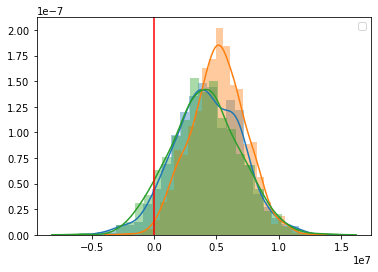

In [33]:
sns.distplot(revenues0)
sns.distplot(revenues1)
sns.distplot(revenues2)
plt.axvline(0, c="r", label="")
plt.legend()

as we see, primarily, revenue for all of regions are profitable (there are some loss cases) 

## 5.2 Find average profit, 95% confidence interval and risk of losses. Loss is negative profit, calculate it as a probability and then express as a percentage.

In [34]:
confidence_interval = st.t.interval(0.95, len(revenues0)-1, revenues0.mean(), revenues0.sem())
loss_risk = len(revenues0[revenues0 < 0]) / len(revenues0)
print(f"""average profit of first region is {revenues0.mean():.2f}, 95% confidence interval is  ({confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}) \
and risk of losses {loss_risk:.2%}""")

average profit of first region is 4278475.60, 95% confidence interval is  (4110802.09, 4446149.11) and risk of losses 5.50%


In [35]:
confidence_interval = st.t.interval(0.95, len(revenues1)-1, revenues1.mean(), revenues1.sem())
loss_risk = len(revenues1[revenues1 < 0]) / len(revenues1)
print(f"""average profit of second region is {revenues1.mean():.2f}, 95% confidence interval is  ({confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}) \
and risk of losses {loss_risk:.2%}""")

average profit of second region is 5115302.18, 95% confidence interval is  (4980530.31, 5250074.06) and risk of losses 0.60%


In [36]:
confidence_interval = st.t.interval(0.95, len(revenues2)-1, revenues2.mean(), revenues2.sem())
loss_risk = len(revenues2[revenues2 < 0]) / len(revenues2)
print(f"""average profit of third region is {revenues2.mean():.2f}, 95% confidence interval is  ({confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}) \
and risk of losses {loss_risk:.2%}""")

average profit of third region is 4085456.81, 95% confidence interval is  (3912282.08, 4258631.55) and risk of losses 7.50%


## 5.3 Provide findings: suggest a region for development of oil wells and justify the choice.

as we could see, most interesting for development region, it's second one. in this case we have most valuable confidence interval with good profit (also mean predicted value and coefficient of determination closed to one, and low RMSE) and risk of losses is around 1%

# Project evaluation

<div class="paragraph">We’ve put together the evaluation criteria for the project. Read this carefully before moving on to the task.</div><div class="paragraph">Here’s what the reviewers will look at when reviewing your project:</div><ul><li>How did you prepare the data for training?</li><li>Have you followed all the steps of the instructions?</li><li>Have you taken into account all the business conditions?</li><li>What are your findings about the task study?</li><li>Have you applied the <em>Bootstrapping</em> technique correctly?</li><li>Have you suggested the best region for well development? Is the choice justified?</li><li>Did you avoid code duplication?</li><li>Have you kept to the project structure and kept the code neat?</li></ul></div>